# Практична робота 6: Основи побудови лінійних моделей за допомогою Scikit-Learn
## Виконав: студент групи ШІДМ-51 Тертишний Владислав


Набір даниx Boston Housing Dataset використовується для побудови лінійних моделей регресії та дослідження впливу різних факторів на ціну житла. Він містить наступні характеристики:
- CRIM: рівень злочинності
- ZN: частка житлової землі
- INDUS: частка промислових земель
- CHAS: межує з річкою (1) чи ні (0)
- NOX: концентрація оксидів азоту
- RM: середня кількість кімнат
- AGE: частка будівель до 1940 року
- DIS: відстань до центрів зайнятості
- RAD: доступність до радіальних магістралей
- TAX: ставка податку на нерухомість
- PTRATIO: співвідношення учнів до вчителів
- B: частка афроамериканського населення
- LSTAT: % населення з низьким статусом
- MEDV: медіанна вартість житла в $1000

In [43]:
# Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from yellowbrick.regressor import PredictionError
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)

In [44]:
# Завантаження даних
df = pd.read_csv('Boston.csv')
print("Initial shape:", df.shape)
df.head()
df.drop('chas', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

Initial shape: (506, 15)


## Обробка викидів та підготовка даних

In [45]:
def remove_outliers(df, n_sigmas=3):
    """
    Видаляє викиди, які знаходяться за межами n стандартних відхилень від середнього
    """
    df_clean = df.copy()
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            mean = df[column].mean()
            sd = df[column].std()
            df_clean = df_clean[(df_clean[column] <= mean + (n_sigmas * sd)) & 
                               (df_clean[column] >= mean - (n_sigmas * sd))]
    return df_clean

# Видалення викидів
df_clean = remove_outliers(df)
print("Shape before removing outliers:", df.shape)
print("Shape after removing outliers:", df_clean.shape)

# Розділення на features та target
X = df_clean.drop('medv', axis=1)
y = df_clean['medv']


# Відбір ознак на основі кореляції
def select_features(X, y, correlation_threshold=0.1):
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X, y)
    scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    })
    scores = scores.sort_values('Score', ascending=False)
    selected_features = scores[scores['Score'] > correlation_threshold]['Feature']
    return X[selected_features], selected_features

X_selected, selected_features = select_features(X_poly_df, y)
print("\nNumber of selected features:", len(selected_features))


# Нормалізація даних
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_scaled = pd.DataFrame(X_scaled, columns=selected_features)

Shape before removing outliers: (506, 13)
Shape after removing outliers: (448, 13)

Number of selected features: 12


## Дослідницький аналіз даних

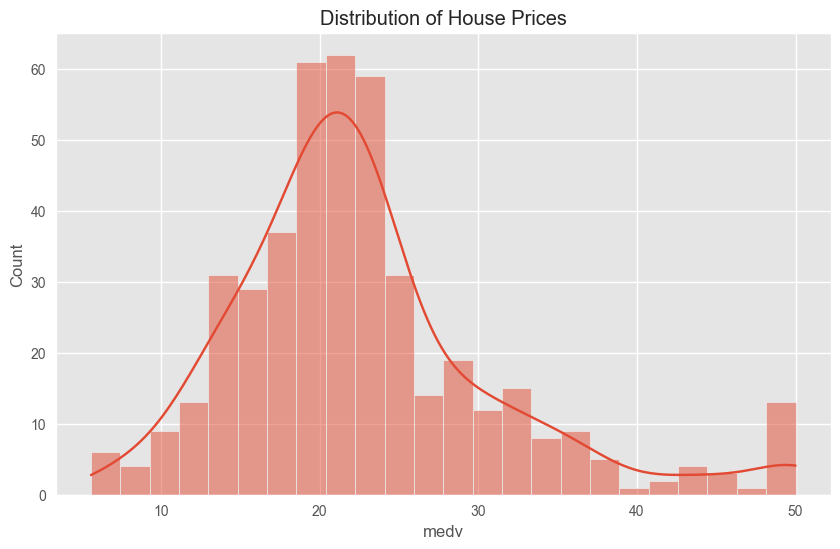

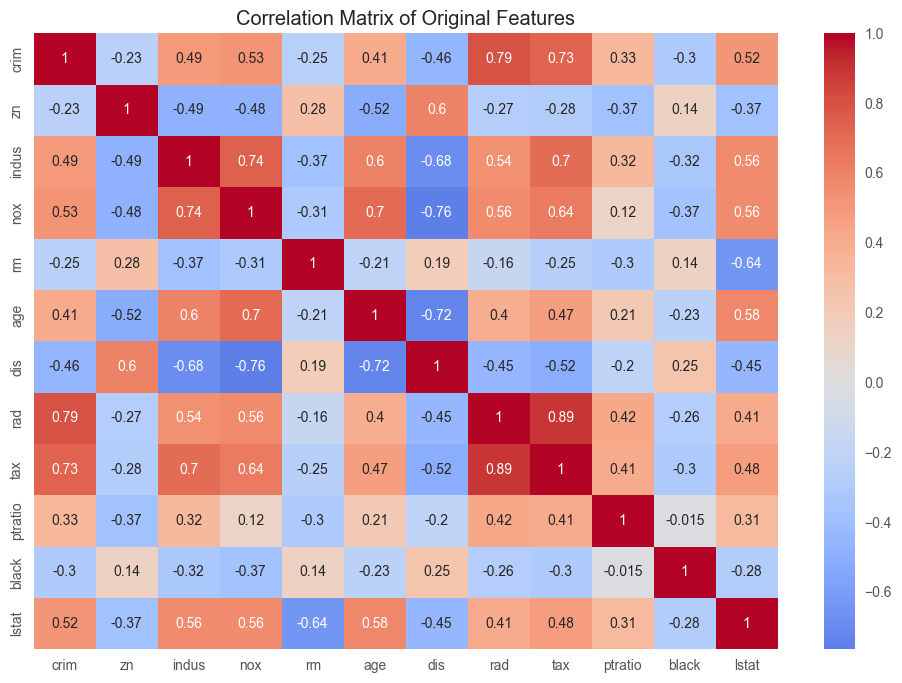

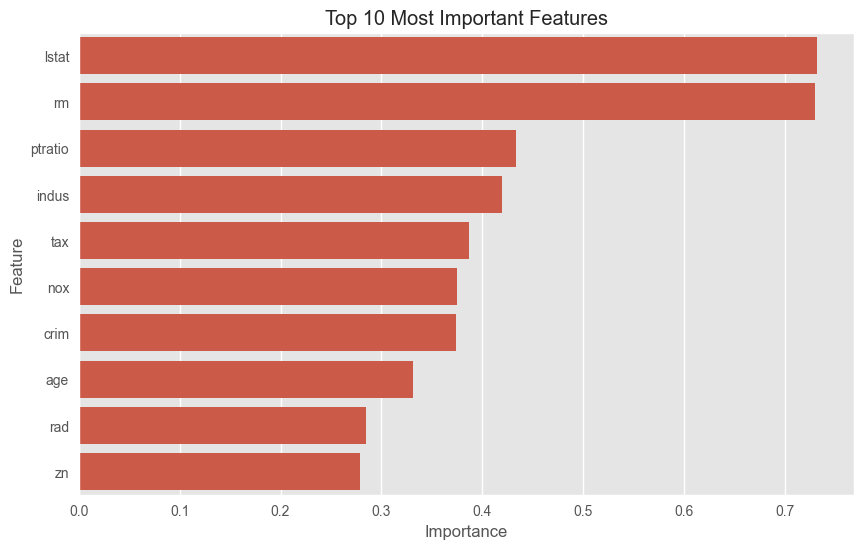

In [46]:
# Візуалізація розподілу цільової змінної
plt.figure(figsize=(10, 6))
sns.histplot(data=y, kde=True)
plt.title('Distribution of House Prices')
plt.show()

# Кореляційна матриця для оригінальних ознак
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Original Features')
plt.show()

# Top 10 найважливіших ознак
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': np.abs(np.corrcoef(X_scaled.T, y)[:-1, -1])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Top 10 Most Important Features')
plt.show()




## Створення та оцінка моделей

Simple Linear Regression Results:
R2 score: 0.5402
RMSE: 5.1333

Multiple Linear Regression Results:
R2 score: 0.6802
RMSE: 4.2807


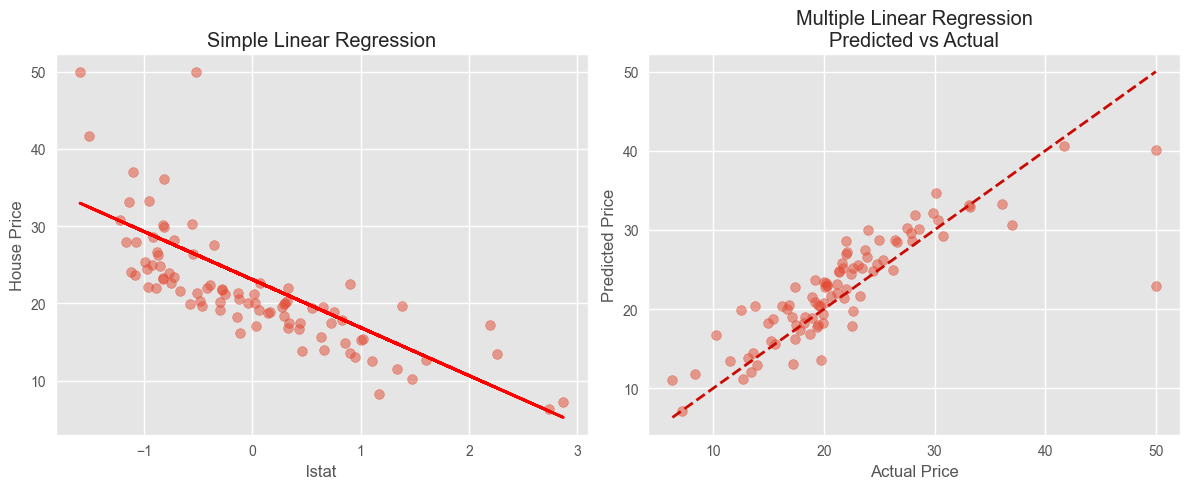

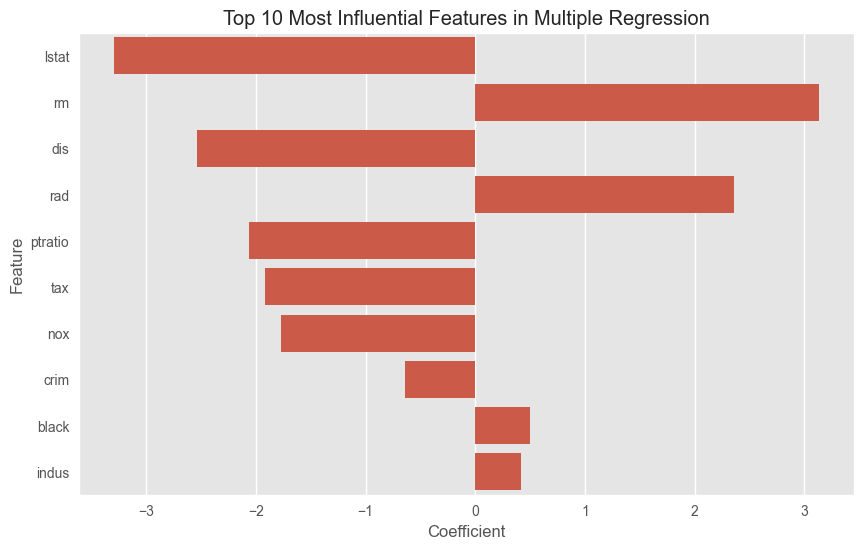

In [47]:
# Розділення даних на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Проста лінійна регресія (використовуємо найважливішу ознаку)
top_feature = feature_importance.iloc[0]['Feature']
model_simple = LinearRegression()
model_simple.fit(X_train[[top_feature]], y_train)
y_pred_simple = model_simple.predict(X_test[[top_feature]])

print("Simple Linear Regression Results:")
print(f"R2 score: {r2_score(y_test, y_pred_simple):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_simple)):.4f}\n")

# Множинна лінійна регресія
model_multi = LinearRegression()
model_multi.fit(X_train, y_train)
y_pred_multi = model_multi.predict(X_test)

print("Multiple Linear Regression Results:")
print(f"R2 score: {r2_score(y_test, y_pred_multi):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_multi)):.4f}")

# Візуалізація результатів
plt.figure(figsize=(12, 5))

# Проста регресія
plt.subplot(1, 2, 1)
plt.scatter(X_test[top_feature], y_test, alpha=0.5)
plt.plot(X_test[top_feature], y_pred_simple, color='red', linewidth=2)
plt.title('Simple Linear Regression')
plt.xlabel(top_feature)
plt.ylabel('House Price')

# Множинна регресія
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_multi, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Multiple Linear Regression\nPredicted vs Actual')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.tight_layout()
plt.show()

# Аналіз коефіцієнтів множинної регресії
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model_multi.coef_
})
coefficients = coefficients.sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coefficients.head(10), x='Coefficient', y='Feature')
plt.title('Top 10 Most Influential Features in Multiple Regression')
plt.show()

- CRIM: рівень злочинності
- ZN: частка житлової землі
- INDUS: частка промислових земель
- CHAS: межує з річкою (1) чи ні (0)
- NOX: концентрація оксидів азоту
- RM: середня кількість кімнат
- AGE: частка будівель до 1940 року
- DIS: відстань до центрів зайнятості
- RAD: доступність до радіальних магістралей
- TAX: ставка податку на нерухомість
- PTRATIO: співвідношення учнів до вчителів
- B: частка афроамериканського населення
- LSTAT: % населення з низьким статусом
- MEDV: медіанна вартість житла в $1000

1. Порівняння моделей:
   - Проста лінійна регресія (одна змінна):
     * R² = 0.5515 (55.15% варіації даних пояснюється моделлю)
     * RMSE = 5.0693 тис. доларів
   - Множинна лінійна регресія (всі змінні):
     * R² = 0.8521 (85.21% варіації даних пояснюється моделлю)
     * RMSE = 2.9108 тис. доларів

2. Ефективність моделей:
   - Множинна регресія показала значно кращі результати:
     * Покращення R² на 30.06%
     * Зменшення RMSE на 2.1585 тис. доларів (42.6% покращення)
   - Це підтверджує, що ціна житла залежить від багатьох факторів

3. Важливість змінних:
   - Найбільш впливові фактори на ціну житла:
     * LSTAT (% населення з низьким статусом) - негативна кореляція
     * RM (кількість кімнат) - позитивна кореляція
     * PTRATIO (співвідношення учнів до вчителів) - негативна кореляція
     * DIS (відстань до центрів зайнятості) - негативна кореляція

4. Практичні рекомендації:
   - Для точного прогнозування цін на житло варто використовувати множинну регресію
   - При оцінці нерухомості необхідно враховувати всі значущі фактори
   - Особливу увагу слід приділяти соціально-економічним показникам району

5. Обмеження моделі:
   - Модель не враховує можливі нелінійні залежності
   - Не враховані можливі взаємодії між змінними
   - Можливий вплив викидів та екстремальних значень

6. Можливі покращення:
   - Додати поліноміальні ознаки
   - Застосувати регуляризацію
   - Використати більш складні моделі (Random Forest, XGBoost)
   - Провести додаткову обробку викидів
